In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from kadi import events
from mica.archive import aca_l0, aca_dark
from Ska.Matplotlib import plot_cxctime, cxctime2plotdate
from astropy.table import Table, unique
from chandra_aca.aca_image import ACAImage
import os.path
from Chandra.Time import DateTime

/proj/sot/ska/arch/x86_64-linux_CentOS-5/lib/python2.7/site-packages/mica/archive/aca_dark/dark_model.py:2: DeprecationWarning: mica.archive.aca_dark.dark_model is deprecated.  See chandra_aca.dark_model
  warnings.warn("mica.archive.aca_dark.dark_model is deprecated.  See chandra_aca.dark_model", DeprecationWarning)

  warnings.warn("mica.archive.aca_dark.dark_model is deprecated.  See chandra_aca.dark_model", DeprecationWarning)



## Goal ##

Estimate the number of new bad pixels that could have been detected dynamically in the ACA level 0 data in the time period between the two most recent ACA DCC measurements.

## Algorithm ##
* Cycle through all level 0 ACA images and for each image get the corresponding section of the 2017/092 ACA DCC map.
* Search for pixels whose corresponding 2017/092 ACA DCC value exceeds 2000 e-/sec.
* For each such pixel store (and save to <code>pixel_file</code>):
    1. Pixel's location (row, col) in ACA CCD coordinates (-512, 511).
    2. Obsid.
    3. Slot.
    4. Current ACA DCC value (2017/092).
    5. Value from the previous ACA DCC measurent (2017/010).
    6. Status (new/old). 'Old' if pixel value was > 2000 e-/sec in the previous DCC measurement.
* Additionally store a footprint of all ACA pixels sampled by the level0 data, and a footprint of edge pixels only.
    
__Notes__
* Readout windows with FIDs also included in the footprint.
* How to deal with the 4x4 images?

In [2]:
# Previous and current ACA DCC maps
dccimg_previous = aca_dark.dark_cal.get_dark_cal_image('2017:010', select='nearest', aca_image=True)
dccimg_current = aca_dark.dark_cal.get_dark_cal_image('2017:092', select='nearest', aca_image=True)

In [3]:
# Get all dwells in the time period between the previous and current ACA DCC
dwells = events.dwells.filter('2017:011', '2017:092')

In [4]:
foot_edge_file = 'foot-edge-pixels-Q1-2017.dat'
foot_all_file = 'foot-all-pixels-Q1-2017.dat'
pixel_file = 'pixels-Q1-2017-gt1500.dat'
threshold = 2000 # e-/sec

# mouse-bitten for 6x6

rs = {4: (0, 0, 0, 0, 3, 3, 3, 3, 1, 2, 1, 2),
      6: (0, 0, 0, 0, 5, 5, 5, 5, 1, 2, 3, 4, 1, 2, 3, 4),
      8: (0, 0, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6)}

cs = {4: (0, 1, 2, 3, 0, 1, 2, 3, 0, 0, 3, 3),
      6: (1, 2, 3, 4, 1, 2, 3, 4, 0, 0, 0, 0, 5, 5, 5, 5),
      8: (0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7)}

edges = {}

for sz in (4, 6, 8):
    edge = np.zeros((sz, sz))
    edge[rs[sz], cs[sz]] = 1
    edges[sz] = edge.astype(bool)

In [5]:
if not os.path.isfile(pixel_file):

    lines = []
    foot_all = ACAImage(np.zeros((1024, 1024)), row0=-512, col0=-512, dtype=bool)
    foot_edge = ACAImage(np.zeros((1024, 1024)), row0=-512, col0=-512, dtype=bool)

    for d in dwells:        
        for slot in range(8):

            slot_imgs = aca_l0.get_l0_images(d.start, d.stop, slot=slot)        

            for img in slot_imgs:

                sz = img.IMGSIZE
                foot_all[img] = 1
                try:
                    foot_edge[img] += edges[sz]
                except ValueError:
                    # decide what to do with the 4x4 images
                    pass
                
                section_previous = dccimg_previous[img]
                section_current = dccimg_current[img]
                r, c = np.nonzero(section_current > threshold)

                for rr, cc in zip(r, c):
                    # log only hot pixels belonging to an edge
                    if (rr, cc) not in [(r_edge, c_edge) for r_edge, c_edge in zip(rs[sz], cs[sz])]:
                        continue
                    row = img.row0 + rr
                    col = img.col0 + cc
                    line = {'obsid': d.get_obsid(), 'slot': slot, 'row': row, 'col': col,
                            'dcc_current': section_current[rr, cc],
                            'dcc_previous': section_previous[rr, cc],
                            'status': 'new'}
                    if section_previous[rr, cc] > threshold:
                        line['status'] = 'old'
                    if line not in lines:
                        lines.append(line)

    # Save footprints
    np.savetxt(foot_all_file, foot_all, fmt='%4i')
    np.savetxt(foot_edge_file, foot_edge, fmt='%4i')
    # Save pixels
    tab = Table(lines)
    tab['dcc_current'].format = '%.0f'
    tab['dcc_previous'].format = '%.0f'
    tab.write(pixel_file, format='ascii')
    
else:
    
    foot_all = np.loadtxt(foot_all_file)
    foot_edge = np.loadtxt(foot_edge_file)
    tab = Table.read(pixel_file, format='ascii')

In [6]:
tab.remove_columns('dcc_previous_scaled')
print(tab.colnames)
print('Sampled hot pixels: {}'.format(len(tab)))

['col', 'dcc_current', 'dcc_previous', 'obsid', 'row', 'slot', 'status']
Sampled hot pixels: 67


In [7]:
t = unique(tab, keys=['row', 'col', 'status'])
print('Unique pixels: {}'.format(len(t)))

Unique pixels: 50


## Hot pixels sampled by level 0 edge data ##

In [8]:
# Marked in red
ok1 = t['dcc_previous'] <= 2000
print('\n{:3d} pixels with > 2000 e-/sec in current DCC, and <= 2000 e-/sec in previous DCC'.format(len(t[ok1])))

# Marked in green
ok2 = t['dcc_previous'] > 2000
print('{:3d} pixels with > 2000 e-/sec in current DCC, and > 2000 e-/sec in previous DCC'.format(len(t[ok2])))


 36 pixels with > 2000 e-/sec in current DCC, and <= 2000 e-/sec in previous DCC
 14 pixels with > 2000 e-/sec in current DCC, and > 2000 e-/sec in previous DCC


## Obsid 18983 ##

In [9]:
print('Observation prior to BSH/090 with hot pixels tracked in slots 6 and 7\n')
ok3 = t['obsid'] == 18983
print(t['obsid', 'slot', 'row', 'col', 'dcc_current', 'dcc_previous', 'status'][ok3])

Observation prior to BSH/090 with hot pixels tracked in slots 6 and 7

obsid slot row  col  dcc_current dcc_previous status
----- ---- ---- ---- ----------- ------------ ------
18983    7 -267 -325        2062         1861    new
18983    3   10  299        2158         1725    new
18983    6   40 -332        2708         1860    new


## Footprint - ACA edge pixels sampled between the 2017/010 and 2017/092 DCCs##

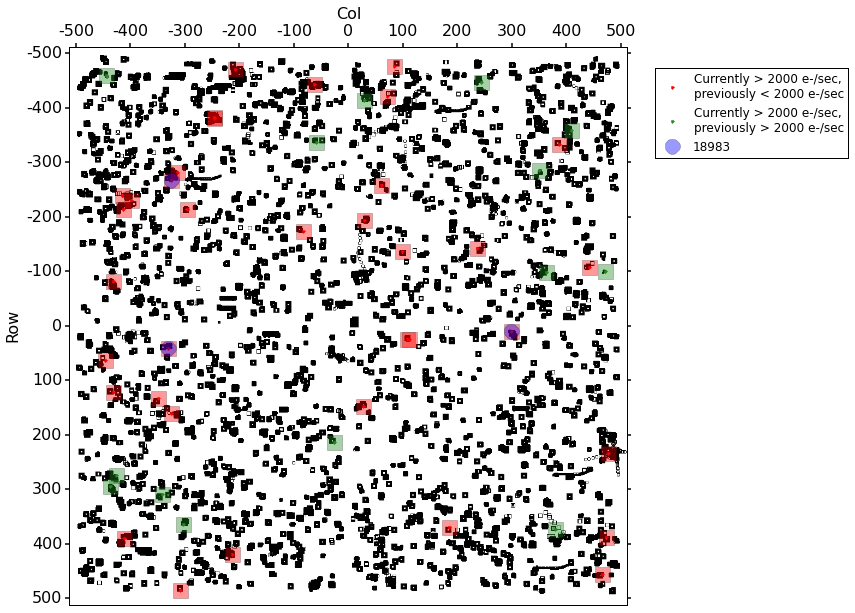

In [10]:
plt.figure(figsize=(10, 10))

plt.imshow(foot_edge, cmap='gist_yarg')

plt.plot(t['col'][ok1] + 512, t['row'][ok1] + 512, '.',
         color='red', label='Currently > 2000 e-/sec,\npreviously < 2000 e-/sec')
plt.plot(t['col'][ok1] + 512, t['row'][ok1] + 512, 's', ms=15,
         color='red', alpha=0.4)

plt.plot(t['col'][ok2] + 512, t['row'][ok2] + 512, '.',
         color='forestgreen', label='Currently > 2000 e-/sec,\npreviously > 2000 e-/sec')
plt.plot(t['col'][ok2] + 512, t['row'][ok2] + 512, 's', ms=15,
         color='forestgreen', alpha=0.4)

plt.plot(t['col'][ok3] + 512, t['row'][ok3] + 512, 'o', ms=15,
         color='blue', alpha=0.4, label='18983')

ax = plt.gca()
ax.xaxis.tick_top()
ax.set_ylabel('Row', fontsize=16)
ax.set_xlabel('Col', fontsize=16)
ax.xaxis.set_label_position('top')
ax.tick_params(direction='out', width=1.5, labelsize=16)

plt.xlim(0, 1024)
plt.ylim(1024, 0)

ticks = np.arange(12, 1112, 100)
labels = [np.str(val) for val in np.arange(-500, 600, 100)]
plt.xticks(ticks, labels)
plt.yticks(ticks, labels)
plt.legend(loc=(1.05, 0.8), numpoints=1);

__Questions__
* What are the thin arch-like features, e.g. at (row, col) = (450, 400), (250, 400), (-250, -300), (-400, 200)?
* Lower density in the center of the image than in the corners?

In [11]:
def pixel_time_series(coords, start, stop, slot, t_ccd=None, edge_only=False):
    """
    Retrieve pixel values as a function of time.
    :: coords :: tuple, native ACA image pixel coordinates
                 in format (row, col), e.g. (-124, 50)
    ::t_ccd:: scale pixel value to this temperature
    """
    vals = []
    times = []
    
    columns = ['TIME', 'BGDAVG', 'IMGSIZE', 'INTEG', 'IMGROW0', 'IMGCOL0', 'TEMPCCD']
    slot_imgs = aca_l0.get_l0_images(start, stop, slot=slot, columns=columns)
        
    for idx, slot_img in enumerate(slot_imgs):
  
        r = coords[0] - slot_img.row0
        c = coords[1] - slot_img.col0

        sz = slot_img.IMGSIZE
        
        val = 0

        if r in range(sz) and c in range(sz):
            if not edge_only or (edge_only and edges[sz][r, c]):
                val = (slot_img[r][c] * 5. / slot_img.INTEG).astype(int)

        scale = 1
        if t_ccd is not None:
            try:
                scale = aca_dark.dark_cal.dark_temp_scale(slot_img.TEMPCCD, t_ccd)
            except AttributeError:
                print(start, DateTime(slot_img.TIME).date)
        vals.append(val * scale)
        times.append(slot_img.TIME)
        
    return times, vals

Obsid 18983. Value of pixel (10, 299) was only ~1000 e-/sec during this observation.
(u'2017:090:16:59:02.241', '2017:090:17:04:33.493')
(u'2017:090:16:59:02.241', '2017:090:17:04:34.518')
(u'2017:090:16:59:02.241', '2017:090:17:04:35.543')
(u'2017:090:16:59:02.241', '2017:090:17:04:36.568')
(u'2017:090:16:59:02.241', '2017:090:17:04:37.593')
(u'2017:090:16:59:02.241', '2017:090:17:04:38.618')


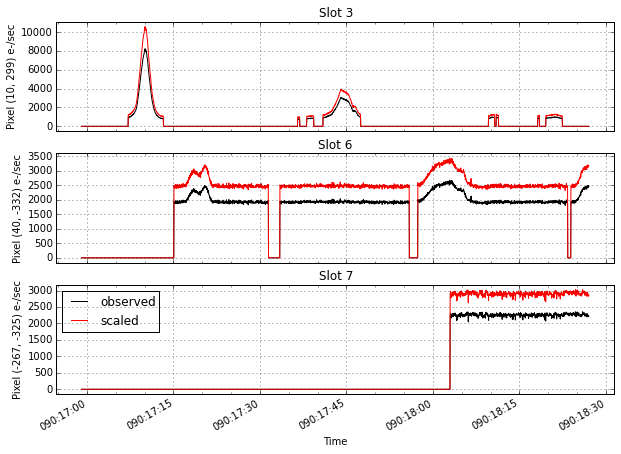

In [12]:
print('Obsid 18983. Value of pixel (10, 299) was only ~1000 e-/sec during this observation.')

plt.figure(figsize=(10, 10))

d = events.dwells.filter(obsid=18983)[0]

props = aca_dark.dark_cal.get_dark_cal_props('2017:092', select='nearest')

for ii, params in enumerate([(3, (10, 299)), (6, (40, -332)), (7, (-267, -325))]):
    plt.subplot(4, 1, ii + 2)
    times_scaled, vals_scaled = pixel_time_series(params[1], d.start, d.stop, params[0], props['ccd_temp'])
    times, vals = pixel_time_series(params[1], d.start, d.stop, params[0])
    plot_cxctime(times, vals, color='k', label='observed')
    plot_cxctime(times_scaled, vals_scaled, color='r', label='scaled')
    plt.grid()
    plt.margins(0.05)
    plt.xlabel('Time')
    plt.ylabel('Pixel {} e-/sec'.format(params[1]))
    plt.title('Slot {}'.format(params[0]))
    
plt.legend(loc='best');

## How many of these pixels would be identified as 'hot' if monitored? ##

In [13]:
# Check this on the complete table, not the one with the unique hot pixels
# e.g. (-381, -247) in obsid 17135 (not detected) and 17136 (detected)
observed_val = []

for ii, tt in enumerate(tab):

    r, c, obsid, slot = tt['row'], tt['col'], tt['obsid'], tt['slot']
    d = events.dwells.filter(obsid=obsid)[0]

    times, vals = pixel_time_series((r, c), d.start, d.stop, slot, edge_only=True)

    vals = np.array(vals)
    nonzero = vals != 0
    mean = 0 if len(vals[nonzero]) == 0 else np.mean(vals[nonzero])
    
    observed_val.append(np.float(mean))

In [14]:
tab['observed_val'] = observed_val
tab['observed_val'].format = '%.0f'

In [15]:
tab.sort('obsid')

In [16]:
detected = tab['observed_val'] > 2000
new = tab['status'] == 'new'

In [17]:
print('Total {}'.format(len(tab[detected * new])))
print(tab[detected * new]['obsid', 'slot', 'row', 'col', 'observed_val'])

Total 15
obsid slot row  col  observed_val
----- ---- ---- ---- ------------
17135    5 -383 -247         2125
17136    6 -383 -247         2157
18983    7 -267 -325         2246
19382    6 -283 -315         2185
19522    5 -108  441         2040
19996    6 -383 -247         2122
50224    0 -383 -247         2152
50226    3 -194   29         2856
50231    6  148   26         2163
50263    3 -214 -296         2036
50272    5 -333  387         2222
50307    4 -142  236         2127
50355    4 -383 -247         2024
50368    4 -383 -247         2034
50372    4 -215 -414         2519


In [18]:
unique_detected = unique(tab[detected * new], keys=['row', 'col'])
print(len(unique_detected))
print(unique_detected)

10
col  dcc_current dcc_previous obsid row  slot status observed_val
---- ----------- ------------ ----- ---- ---- ------ ------------
-247        2285         1844 17135 -383    5    new         2125
 387        2311         1391 50272 -333    5    new         2222
-315        2391         1325 19382 -283    6    new         2185
-325        2062         1861 18983 -267    7    new         2246
-414        2777         2000 50372 -215    4    new         2519
-296        2703         1987 50263 -214    3    new         2036
  29        3016         1576 50226 -194    3    new         2856
 236        2453         1900 50307 -142    4    new         2127
 441        2184         1699 19522 -108    5    new         2040
  26        2385         1831 50231  148    6    new         2163


In [19]:
hotish = (tab['observed_val'] < 2000) * (tab['observed_val'] > 1500)
print(len(tab[new * hotish]))
print(len(tab[new * hotish]))

26
26


In [20]:
unique_hotish = unique(tab[new * hotish], keys=['row', 'col'])
print(len(unique_hotish))
print(unique_hotish)

19
col  dcc_current dcc_previous obsid row  slot status observed_val
---- ----------- ------------ ----- ---- ---- ------ ------------
-208        2039         1349 20000 -472    3    new         1961
 -64        2298         1712 50223 -443    1    new         1916
  71        2129         1601 19863 -421    1    new         1593
-247        2285         1844 50349 -383    4    new         1981
-247        2079         1431 17135 -381    5    new         1721
  59        2102         1493 50342 -259    1    new         1935
-416        2188         1747 50285 -241    7    new         1807
-399        2082         1626 50285 -231    7    new         1751
-414        2777         2000 50262 -215    2    new         1983
 -84        2071         1429 50345 -174    4    new         1786
  98        2187         1605 50294 -137    1    new         1766
-432        2173         1625 19381  -83    7    new         1871
 111        2785         1904 50356   25    6    new         1692
-332   

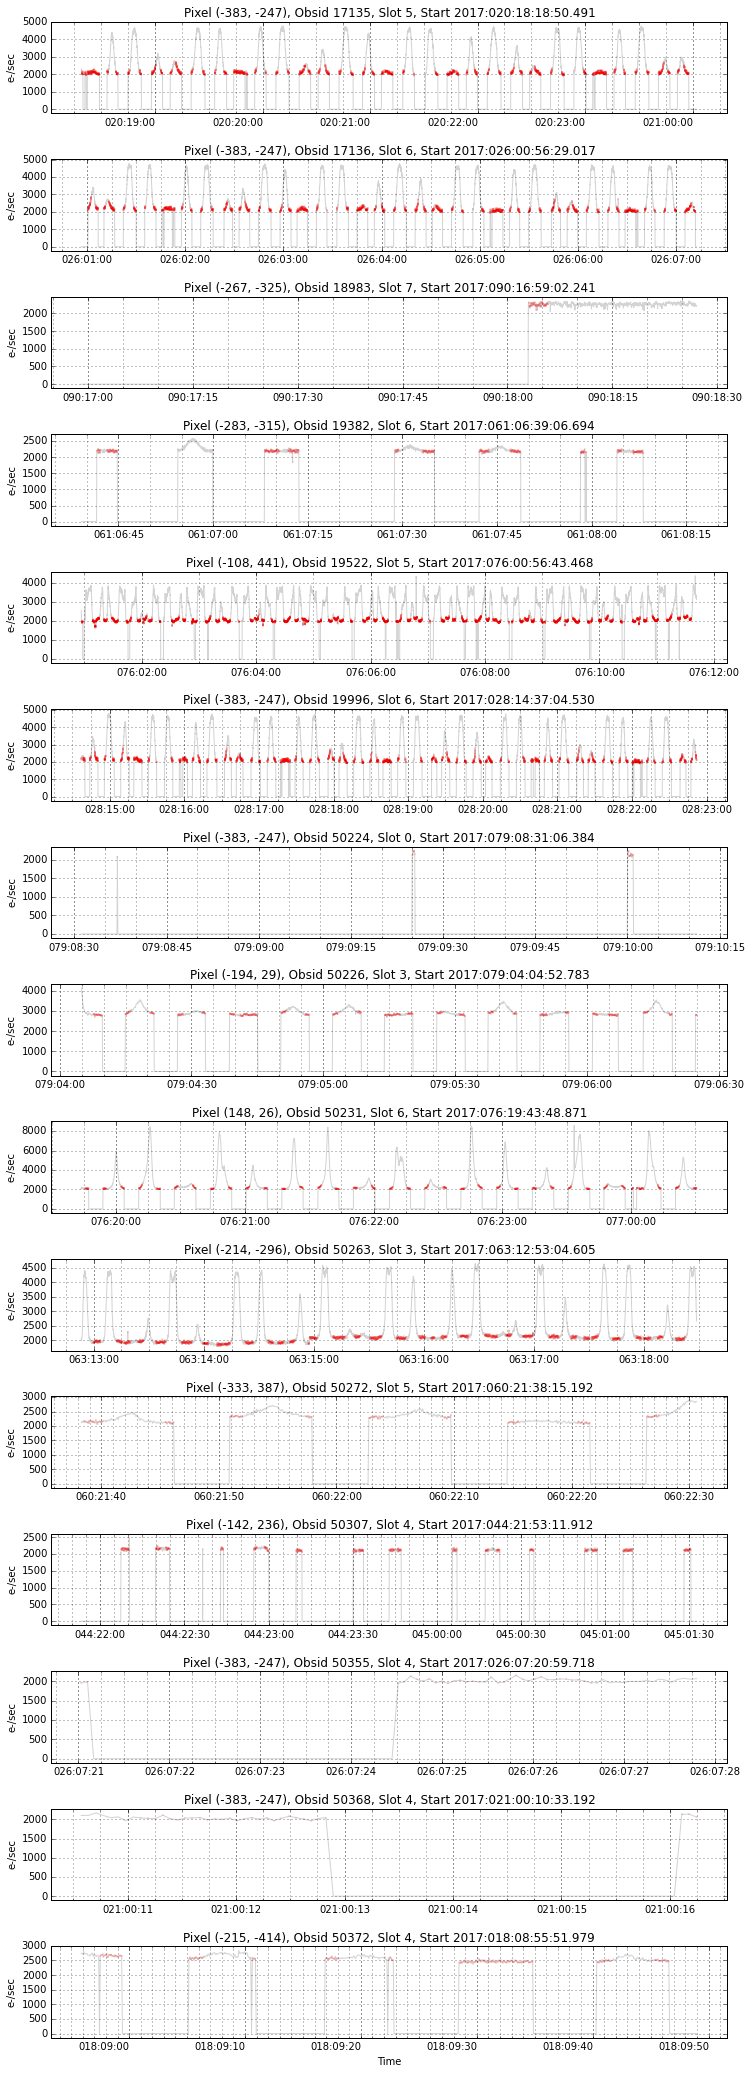

In [21]:
plt.figure(figsize=(10, 40))

for ii, tt in enumerate(tab[detected * new]):

    plt.subplot(len(tab[detected * new]), 1, ii + 1)
    r, c, obsid, slot = tt['row'], tt['col'], tt['obsid'], tt['slot']
    d = events.dwells.filter(obsid=obsid)[0]
    times, vals = pixel_time_series((r, c), d.start, d.stop, slot, edge_only=True)
    times_all, vals_all = pixel_time_series((r, c), d.start, d.stop, slot)
    #times_scaled, vals_scaled = pixel_time_series((r, c), d.start, d.stop, slot, props['ccd_temp'], edge_only=True)
    plot_cxctime(times_all, vals_all, color='lightgray')
    nonzero = np.array(vals) > 0
    plot_cxctime(np.array(times)[nonzero], np.array(vals)[nonzero],
                 color='r', marker='.', ms=0.5, ls='None', label='observed')
    #plot_cxctime(times_scaled, vals_scaled, color='r', label='scaled')
    plt.grid(which='both')
    plt.margins(0.05)
    plt.xlabel('Time')
    plt.ylabel('e-/sec')
    plt.title('Pixel {}, Obsid {}, Slot {}, Start {}'.format((r, c), obsid, slot, DateTime(d.start).date))

axes = plt.gcf().axes
for axis in axes:
    plt.setp(axis.get_xticklabels(), visible=True, rotation=0)

plt.subplots_adjust(left=0.05, bottom=0.2, right=0.99, top=0.9, hspace=0.5, wspace=0.3)
#plt.legend(loc='best');

__Figure.__ Red color marks times when hot pixel was an edge pixel.

# Work in progress #

In [22]:
# Test of edge pixels
d = events.dwells.filter(obsid=17136)
imgs = aca_l0.get_l0_images('2017:026:01:13:00', '2017:026:01:15:00', slot=6)
for img in imgs[:5]:
    if img.TIME in np.array(times)[nonzero]:
        print(img * 5. / img.INTEG, img.row0, img.col0, img.IMGSIZE)

In [23]:
# Large one-shot day 119, 50115
d = events.dwells.filter(obsid=50115)[0]
imgs = aca_l0.get_l0_images(d.start, d.stop, slot=7)

import collections
hpimgs = collections.OrderedDict()
hp = collections.OrderedDict()

for img in imgs:
    val = np.float(np.max(img) * 5. / img.INTEG)
    if val > 1300.:
        r, c = np.unravel_index(np.argmax(img), dims=img.shape)
        if dccimg_current[img][r, c] > 1000:
            coords = (r + img.row0, c + img.col0)
            if coords not in hp.keys():
                hp[coords] = [val]
            else:
                hp[coords].append(val) 
            hpimgs[DateTime(img.TIME).date] = img
            #print(img, img.row0, img.col0, DateTime(img.TIME).date, img.BGDAVG)
            #print(r, c)

testvals = []
for img in imgs:
    coords = hp.keys()[0]
    r = coords[0] - img.row0
    c = coords[1] - img.col0
    if r in range(img.IMGSIZE) and c in range(img.IMGSIZE):
        testvals.append(img[r, c])
    else:
        testvals.append(0)

In [24]:
print(hp.keys())
print(foot_edge[162, -355])

[(162, -355)]
1.0


In [25]:
tt = []
vv = []
for slot in range(8):
    times, vals = pixel_time_series((162, -355), '2017:010:00:00:00', '2017:092:00:00:00', slot, edge_only=True)
    tt.append(times)
    vv.append(vals)

In [26]:
len(vv)
len(tt)
np.sum(vv[2])

981

<IPython.core.display.Javascript object>


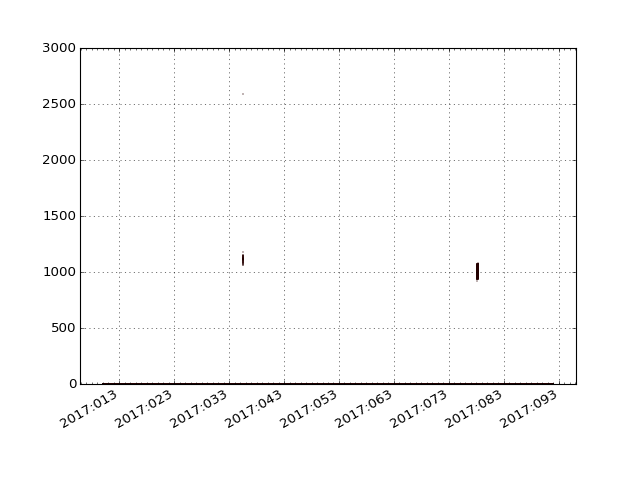

/proj/sot/ska/arch/x86_64-linux_CentOS-5/lib/python2.7/site-packages/matplotlib/backends/backend_webagg_core.py:210: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  buff.shape = (renderer.height, renderer.width)

  buff.shape = (renderer.height, renderer.width)



In [27]:
%matplotlib notebook
#nonzero = np.array(vals) > 0
#plot_cxctime(np.array(tt)[nonzero], np.array(vv)[nonzero],
#             color='r', marker='.', ms=0.5, ls='None', label='observed')
plot_cxctime(np.array(tt[0]), np.array(vv[0]),
             color='r', marker='o', ms=0.5, ls='None', label='observed')
plt.grid()
plt.margins(0.05)
plt.xlabel('Time')
plt.ylabel('e-/sec')
plt.title('Pixel {}, Obsid {}'.format((162, -355), obsid));

<IPython.core.display.Javascript object>


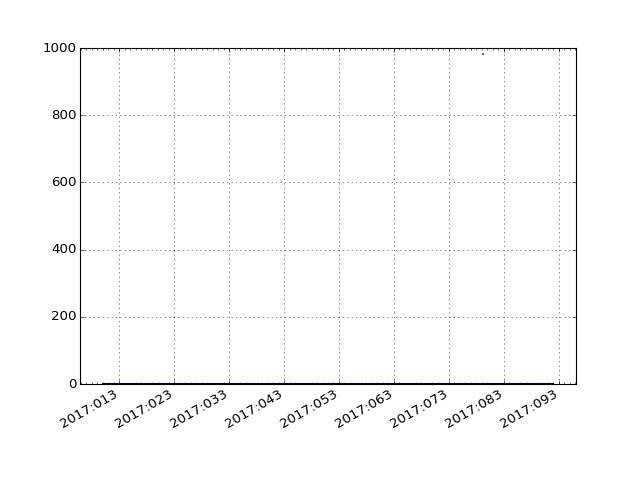

In [28]:
%matplotlib notebook
#nonzero = np.array(vals) > 0
#plot_cxctime(np.array(tt)[nonzero], np.array(vv)[nonzero],
#             color='r', marker='.', ms=0.5, ls='None', label='observed')
plot_cxctime(np.array(tt[2]), np.array(vv[2]),
             color='b', marker='o', ms=1, ls='None', label='observed')
plt.grid()
plt.margins(0.05)
plt.xlabel('Time')
plt.ylabel('e-/sec')
plt.title('Pixel {}, Obsid {}'.format((162, -355), obsid));

In [29]:
d = events.dwells.filter(start='2017:079:02:25:30', stop='2017:079:06:26:30')[0]
obsid = d.get_obsid()
print(obsid, d.start)

(18971, u'2017:079:02:02:13.283')


In [30]:
imgs = aca_l0.get_l0_images('2017:079:06:26:40', '2017:079:06:26:42', slot=2)
imgs

[<ACAImage row0=162 col0=-361
 array([[ 16,   2,   2,  49,  81,  75, 333,  19],
        [ 16,  29,   5,   4,  17,   2,  34, 163],
        [127, 131,  58,  48,  54,  58,  17,   6],
        [202, 178, 171, 187, 173, 135,  75,  50],
        [196, 155, 151, 161, 156, 114, 132,  46],
        [ 65,  65,  73, 106,  85,  81,  97,  29],
        [125,   8,  48,  37,  19,  73,  14,  29],
        [  2,   4,   5,  72,   7,  26,   3,  60]])>]

In [31]:
d = events.dwells.filter(start='2017:078:02:00:30', stop='2017:078:07:26:30')[1]
obsid = d.get_obsid()
print(obsid, d.start)

(19850, u'2017:078:02:30:55.978')


In [32]:
imgs = aca_l0.get_l0_images(d.start, d.stop, slot=0)
for img in imgs[:20]:
    print(img, DateTime(img.TIME).date)

(<ACAImage row0=157 col0=-355
array([[  11,  132,   45,  114,  201,  123,   63,   37],
       [  37,  114,  184,  340,  772,  391,   88,   45],
       [  80,  227,  937, 2936, 2244,  617,  192,  123],
       [  97,  383, 1785, 8788, 8044, 1768,  348,   80],
       [  88,  210,  720, 3802, 3508,  876,  495,   88],
       [ 322,   63,  106,  314,  366,  305,  201,   88],
       [  37,  184,   71,   97,  114,   71,   45,   54],
       [  11,   19,  140,   97,   54,  106,   28,   19]])>, '2017:078:02:30:57.180')
(<ACAImage row0=157 col0=-355
array([[  10,  131,   36,  131,  200,  114,   45,   36],
       [  45,  114,  192,  347,  778,  398,   97,   54],
       [  79,  226,  907, 2926, 2253,  640,  200,  122],
       [  79,  407, 1761, 8756, 7997, 1761,  330,   88],
       [  88,  226,  726, 3754, 3538,  890,  493,   97],
       [ 321,   62,   97,  312,  381,  312,  200,   88],
       [  45,  183,   71,   88,  114,   71,   45,   45],
       [  19,   19,  148,  105,   71,  105,   19,   19]])

In [33]:
# Check the effect of these hot pixels on the centroids, TODO
from Ska.engarchive import fetch as fetch
dat = fetch.MSIDset(['aoacyan*', 'aoaczan*', 'aoacmag*'], d.start, d.stop)

<IPython.core.display.Javascript object>


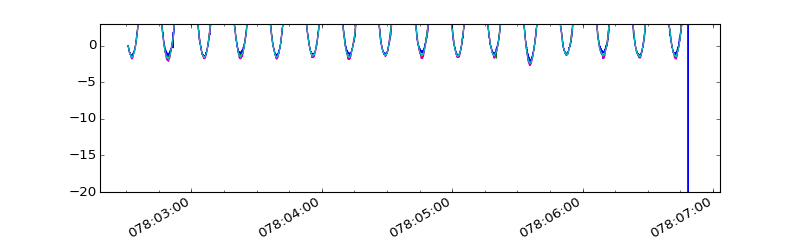

In [34]:
%matplotlib notebook
plt.figure(figsize=(10, 3))
colors = 'rgbmc'
for slot in (3, 4, 5, 6, 7):
    msid = dat['aoacyan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - msid.vals[0], colors[slot - 3], label='Slot {}'.format(slot))
plt.ylim(-20, 3)
plt.margins(0.05);

<IPython.core.display.Javascript object>


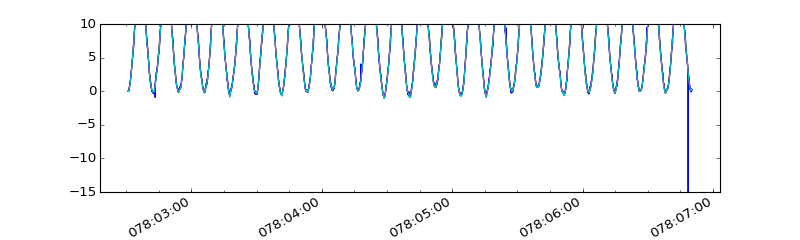

In [35]:
%matplotlib notebook
plt.figure(figsize=(10, 3))
colors = 'rgbmc'
for slot in (3, 4, 5, 6, 7):
    msid = dat['aoaczan{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals - msid.vals[0], colors[slot - 3], label='Slot {}'.format(slot))
plt.ylim(-15, 10)
plt.margins(0.05);

<IPython.core.display.Javascript object>


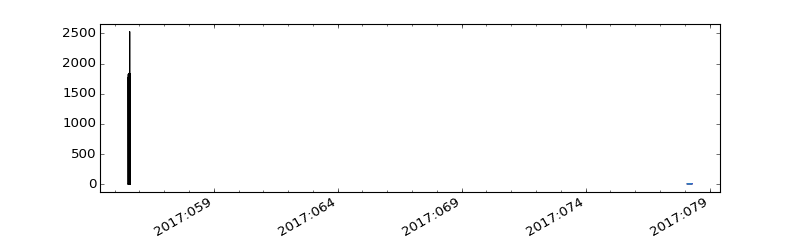

In [36]:
%matplotlib notebook
plt.figure(figsize=(10, 3))
colors = 'rgbmc'
for slot in (3, 4, 5, 6, 7):
    msid = dat['aoacmag{}'.format(slot)]
    plot_cxctime(msid.times, msid.vals, colors[slot - 3], label='Slot {}'.format(slot))
plt.margins(0.05);

In [37]:
# Check the obsid with nan/0, t[idx = 17]
r, c, obsid, slot = t[17]['row'], t[17]['col'], t[17]['obsid'], t[17]['slot']
d = events.dwells.filter(obsid=obsid)[0]
times, vals = pixel_time_series((r, c), d.start, d.stop, slot)
plot_cxctime(times, vals, 'k');

In [38]:
slot_imgs = aca_l0.get_l0_images(d.start, d.stop, slot=slot)

In [39]:
img = slot_imgs[0]
img

<ACAImage row0=-241 col0=-407
array([[  7,  11,  27,  30,  40,  25,   5,  10],
       [  8, 175,  31,  28,  70,   8,  23, 118],
       [ 11,  60, 101, 294, 187,  55,  19,  39],
       [ 44,  26, 467, 245, 313, 181,  24,  12],
       [ 53,  18, 164, 150, 256, 248,  28,   4],
       [  4,   2,  15,  92, 212,  57,  34,   5],
       [  4,  14,   4,  16,  34,  29,   6,  16],
       [ 43,  32,  37,  82,  13,  10,  34,  16]])>